In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

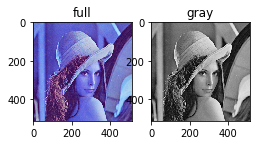

In [2]:
originImage = cv2.imread("../lena.jpg")
grayImage = cv2.cvtColor(originImage,cv2.COLOR_BGR2GRAY)
originImage32x32 = cv2.imread("../lena_32x32.jpg")
grayImage32x32 = cv2.cvtColor(originImage32x32,cv2.COLOR_BGR2GRAY)
plt.subplot(1, 3, 1)
plt.title("full")
plt.imshow(originImage)
plt.subplot(1, 3, 2)
plt.title("gray")
plt.gray()
plt.imshow(grayImage)

In [3]:
def show_img(src,desc,r,c,Iid):
    plt.subplot(r, c, Iid)
    plt.title(desc)
    plt.imshow(src)


kernel: 
[[ 1.  0.]
 [ 0. -1.]]
dst_full[0:2,0:2]:
[[  0   0]
 [  0 162]]

In [41]:
A=np.array(([[ 1.,  0.],[ 0., -1.]]),np.float32)
B=np.array(([[  0 ,  0,1], [  0 ,162,1]]),np.float32)
print(A)
print(B[0:2,0:2])
print(A*B[0:2,0:2])
print(np.sum(A*B[0:2,0:2]))

[[ 1.  0.]
 [ 0. -1.]]
[[   0.    0.]
 [   0.  162.]]
[[   0.    0.]
 [   0. -162.]]
-162.0


In [46]:
# full类型卷积操作.
#
# ax,ay: anchor's location

def conv2d_same(src,kernel,ax,ay,stride):
    kw,kh=kernel.shape
    iwo,iho=src.shape
    r=int(kw/2)
    dst=src.copy()
    dst_full=np.pad(dst,((r,r),(r,r)),constant_values=(0,0),mode='constant') # 扩充2r个0
    dst_full=dst_full.astype(np.float32)
    dest = dst_full.copy()
    i=j=r
    iw,ih=dest.shape
    #print("r:%d,iw:%d,ih:%d,pad_iw:%d,pad_ih:%d" %(r,iwo,iho,iw,ih))
    debug_cnt=0
    if kw%2==1:
        odds=1
    else:
        odds=0
    print("i:%d,iw:%d,ih:%d,r:%d,odds:%d" %(i,iw,ih,r,odds))
    sax=ax
    say=ay
    while i< (iw+2*r-r-odds-1):
        while j<(ih+2*r-r-odds-1):
            temp=kernel*dst_full[(i-r):(i+r+odds),(j-r):(j+r+odds)]
            '''
            if debug_cnt<10:
                print("[i:%d,j:%d]origin dest[%d,%d]:%d" %(i,j,ax,ay,dest[ax,ay]))
                print("kernel:",kernel)
                print("dst_full[%d:%d,%d:%d]:%s" %((i-r),(i+r+odds),(j-r),(j+r+odds),dst_full[(i-r):(i+r+odds),(j-r):(j+r+odds)]))
            '''
            dest[ax,ay]=np.sum(temp)
            '''
            if debug_cnt<10:
                debug_cnt+=1
                print("[i:%d,j:%d]after dest[%d,%d]:%d" %(i,j,ax,ay,dest[ax,ay]))
            '''
            j+=stride
            ay+=stride
        i+=stride
        ax+=stride
        j=r
        ay=say # 易忘记,参数的回归,迭代,更新.

    return dest

def conv1d_same(src,kernel,ax,ay,stride):
    kw,kh=kernel.shape
    if kw<=1 and kh <=1:
        print("wrong kernel size")
        return 
    if kh==1: # 一行n列的kernel,按行卷积
        r=int(kw/2)
        dst=src.copy()
        dst_full=np.pad(dst,((r,r),(0,0)),constant_values=(0,0),mode='constant') # 扩充2r个0
        dest = dst_full.copy()
        iw,ih=dest.shape
        #odds=(kw%2==1)?1:0
        if kw%2==1:
            odds=1
        else:
            odds=0
        while i<iw+2*r-r-odds-1:
            while j<ih-1:
                temp=kernel*dst_full[(i-r):(i+r+odds),j]
                dest[ax,ay]=np.sum(temp)
                ax+=stride
                i+=stride
            j+=1
            ay+=1 # 很容易就忘记了迭代
    elif kw==1:# n行一列
        r=int(kh/2)
        dst=src.copy()
        dst_full=np.pad(dst,((0,0),(r,r)),constant_values=(0,0),mode='constant') # 扩充2r个0
        dest = dst_full.copy()
        iw,ih=dest.shape
        #odds=(kh%2==1)?1:0
        if kh%2==1:
            odds=1
        else:
            odds=0
        while i<iw-1:
            while j<ih+2*r-r-odds-1:
                temp=kernel*dst_full[i,(j-r):(j+r+odds)]
                dest[ax,ay]=np.sum(temp)
                ay+=stride
                j+=stride
            i+=1
            ax+=1
    
    return dest

i:1,iw:514,ih:514,r:1,odds:0
i:1,iw:514,ih:514,r:1,odds:0
[[162 162 162 ..., 170 156 128]
 [162 163 162 ..., 169 155 129]
 [163 162 163 ..., 170 154 128]
 ..., 
 [ 43  43  49 ..., 104 100  98]
 [ 44  44  55 ..., 104 104 108]
 [ 44  43  53 ..., 104 105 108]]


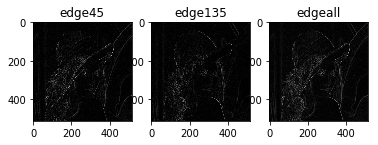

In [47]:
def roberts_edge(src):
    # 生成两个roberts算子
    R1=np.array([[1,0],[0,-1]],np.float32)
    R2=np.array([[0,1],[-1,0]],np.float32)
    IconR1=conv2d_same(src,R1,0,0,stride=1)
    IconR2=conv2d_same(src,R2,0,1,stride=1)
    IconR1=np.abs(IconR1)
    IconR1=IconR1.astype(np.uint8)
    IconR2=np.abs(IconR2)
    IconR2=IconR2.astype(np.uint8)
    show_img(IconR1,"edge45",1,3,1)
    show_img(IconR2,"edge135",1,3,2)
    #cv2.imshow("edge45",IconR1)
    #cv2.imshow("edge135",IconR2)
    edge_all=np.sqrt(np.power(IconR1,2.0)+np.power(IconR2,2.0))
    edge_all=np.round(edge_all)
    edge_all[edge_all>255]=255
    edge_all=edge_all.astype(np.uint8)
    show_img(edge_all,"edgeall",1,3,3)
    #cv2.imshow("edgeall",edge_all)

roberts_edge(grayImage)
print(grayImage)

[[ 162.  162.  162. ...,  156.  128.    0.]
 [ 162.    1.    0. ...,  -15.  -27. -128.]
 [ 163.    0.    0. ...,  -15.  -27. -129.]
 ..., 
 [  44.    1.   12. ...,    0.    8.  -98.]
 [  44.   -1.    9. ...,    1.    4. -108.]
 [   0.  -44.  -43. ..., -104. -105. -108.]]


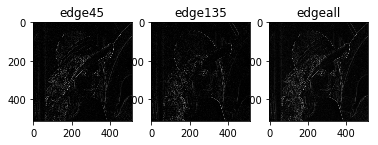

In [12]:
from scipy import signal
def roberts_with_conv2d_api(src):
    R1=np.array([[1,0],[0,-1]],np.float32)
    R2=np.array([[0,1],[-1,0]],np.float32)
    IconR1=signal.convolve2d(src,R1,mode='full',boundary='fill',fillvalue=0)
    IconR2=signal.convolve2d(src,R2,mode='full',boundary='fill',fillvalue=0)
    print(IconR1)
    IconR1=np.abs(IconR1)
    IconR1=IconR1.astype(np.uint8)
    IconR2=np.abs(IconR2)
    IconR2=IconR2.astype(np.uint8)
    show_img(IconR1,"edge45",1,3,1)
    show_img(IconR2,"edge135",1,3,2)
    #cv2.imshow("edge45",IconR1)
    #cv2.imshow("edge135",IconR2)
    edge_all=np.sqrt(np.power(IconR1,2.0)+np.power(IconR2,2.0))
    edge_all=np.round(edge_all)
    edge_all[edge_all>255]=255
    edge_all=edge_all.astype(np.uint8)
    show_img(edge_all,"edgeall",1,3,3)
    #cv2.imshow("edgeall",edge_all)
    

roberts_with_conv2d_api(grayImage)

#### prewitt算子

可分离卷积核.
![prewitt算子](https://gss2.bdstatic.com/-fo3dSag_xI4khGkpoWK1HF6hhy/baike/c0%3Dbaike72%2C5%2C5%2C72%2C24/sign=cb3bb6b043166d222c7a1dc6274a6292/ca1349540923dd54c88e9613d109b3de9d8248cf.jpg)

In [ ]:
def prewitt(src):
    # 垂直方向平滑,水平方向差分